# The @fit_output decorator

The `@fit_output` decorator ensures a consistent output format across different optimization methods and libraries, making it easier to work with fit results in a standardized way.


If you're new to decorators, think of them as a way to extend a function’s behavior without modifying its core logic. In this case, `@fit_output` enhances fit functions by computing additional metrics and providing visualization tools automatically.


This is possible because the decorator can recognize and distinguish the outputs of the most used `scipy.optimize` and `lmfit` functions. Once the library and fit method has been recognized, `@fit_output` computes missing metrics and rearranges the output in a standardized format.

The output of all the fit functions that use the decorator is a [FitResult](../../API%20reference/fit/core/#sqil_core.fit._core.FitResult), which gives you access to useful information, such as:
- `.params`, the optimized parameters
- `.std_err`, the standard error on the parameters
- `.metrics`, metrics used to evaluate the goodness of the fit
- `.output`, the raw output of the fit function
- `.predict`, a function of only x, used to make predictions using the fitted parameters
- `.metadata`, additional information

In some cases not all of this information can be extracted from the raw fit output, especially the prediction function. If that's the case, you can pass these parameters manually, as we'll see in the following examples.

## Lorentzian fit example
Let's define the lorentzian function and create some synthetic data for our example

In [1]:
import numpy as np

# Define the Lorentzian function
def lorentzian(x, A, x0, w):
    return (A / np.pi) * (w / ((x - x0)**2 + w**2))

# Generate synthetic data
true_params = [1, 0, 2]  # A=1, x0=0, w=2
np.random.seed(11)
x_data = np.linspace(-10, 10, 100)
noise = 0.01 * np.random.normal(size=len(x_data))
y_data = lorentzian(x_data, *true_params) + noise  # Add noise

### Without the decorator

Let's look at an example of a lorentzian fit using `scipy`'s `curve_fit`.


**Step 1**: we perform the optimization using `curve_fit`

In [2]:
from scipy.optimize import curve_fit

# Fit the data using curve_fit
popt, pcov = curve_fit(lorentzian, x_data, y_data, p0=[1, 0, 1])

**Step 2**: extract the parameters and compute the chi-squared and the standard errors to evaluate the goodness of the fit

In [3]:
# Extract fitted parameters
A_fit, x0_fit, w_fit = popt
print(f"Fitted parameters: A={A_fit:.3f}, x0={x0_fit:.3f}, w={w_fit:.3f}")

# Extract standard errors (diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
print(f"Standard errors: A={perr[0]:.3f}, x0={perr[1]:.3f}, w={perr[2]:.3f}")

# Compute the chi-squared value
y_fit = lorentzian(x_data, *popt)  # Fitted curve
residuals = y_data - y_fit
chi_squared = np.sum((residuals)**2)
print(f"Chi-squared: {chi_squared:.3f}")

Fitted parameters: A=1.007, x0=0.044, w=2.015
Standard errors: A=0.022, x0=0.043, w=0.061
Chi-squared: 0.009


While this is a valid way of performing the fit, there are a few issues.
- There is no immediate way of assessing the fit quality
- While we have the covariance matrix, the standard errors are not immediately available
- There is no easy way of printing the parameters and their respective errors

### With the decorator

**Step 1**: create the fit function and apply the decorator

In [4]:
from sqil_core.fit import fit_output

@fit_output
def fit_lorentzian(x_data, y_data):
    result = curve_fit(lorentzian, x_data, y_data, p0=[1, 0, 1], full_output=True)
    return result

**Step 2**: run the optimization and print the summary

In [5]:
fit_result = fit_lorentzian(x_data, y_data)

fit_result.summary()

reduced χ²	8.869e-05	GREAT (or overfitting)
|   Param |   Fitted value |   STD error |   % Error |
|---------|----------------|-------------|-----------|
|       0 |      1.00732   |   0.0002031 |      0.02 |
|       1 |      0.0435118 |   0.0004014 |      0.92 |
|       2 |      2.01523   |   0.0005755 |      0.03 |



The result is much easier to read.<br>
`fit_result` is now a `FitResult` object, which contains even more information. You can read more about it [here](../../API%20reference/fit/core/#sqil_core.fit._core.FitResult).<br>
From `fit_result` we can access the following properties:

In [6]:
# Prints a summary of the fit, including parameters values, their error
# and metrics to evaluate the goodness of the fit.
fit_result.summary#()

# The parameters as a numpy array
fit_result.params

# The standard errror on the parameters as a numpy array
fit_result.std_err

# Fit metrics (like reduced chi-squared)
fit_result.metrics

# The raw output of the optimization, in this case it's the
# output of scipy curve_fit
fit_result.output

# Names of the parameters (not always available)
fit_result.param_names

# Predict y given x, with the current optimized parameters (not always available)
fit_result.predict#(x_fit)
;

''

You may have noticed that some attributes are not always available, that's because they can't be guessed from the optimizer's output. However, you can still provide them to the decorator by returning a tuple in your fit function, instead of just the optimizer's output. The tuple should contain a second element, `metadata`, which is a dictionary used to provide additional information. 

In the example below we manually add the parameter's names, this way the `summary()` becomes easier to read.

In [7]:
@fit_output
def fit_lorentzian(x_data, y_data):
    result = curve_fit(lorentzian, x_data, y_data, p0=[1, 0, 1], full_output=True)
    metadata = {
        "param_names": ["A", "x0", "w"]
    }
    return result, metadata

fit_result = fit_lorentzian(x_data, y_data)
fit_result.summary()

reduced χ²	8.869e-05	GREAT (or overfitting)
| Param   |   Fitted value |   STD error |   % Error |
|---------|----------------|-------------|-----------|
| A       |      1.00732   |   0.0002031 |      0.02 |
| x0      |      0.0435118 |   0.0004014 |      0.92 |
| w       |      2.01523   |   0.0005755 |      0.03 |



**Step 3**: vistualize the results

In the metadata dictionary we can also pass a function that can be used to evaluate the fit on a given x vector. In our case it's the `lorenzian` function. The decorator takes care of passing the right parameters into this prediction function, which will depend only on x.

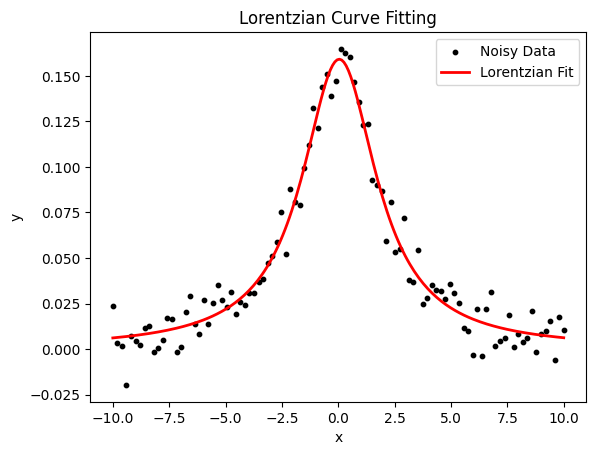

In [8]:
@fit_output
def fit_lorentzian(x_data, y_data):
    result = curve_fit(lorentzian, x_data, y_data, p0=[1, 0, 1], full_output=True)
    metadata = {
        "param_names": ["A", "x0", "w"],
        "predict": lorentzian
    }
    return result, metadata

# Perform the fit
fit_result = fit_lorentzian(x_data, y_data)

# Compute fitted curve
x_fit = np.linspace(-10, 10, 200)
y_fit = fit_result.predict(x_fit)

# Plot result
import matplotlib.pyplot as plt
plt.scatter(x_data, y_data, label="Noisy Data", color="black", s=10)
plt.plot(x_fit, y_fit, label="Lorentzian Fit", color="red", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lorentzian Curve Fitting")
plt.legend()
plt.show()

### With other fit libraries/methods

The power of the decorator lies also in its ability to standardize output from libraries or methods. For example, the output given by scipy `minimize` is different from the output of scipy `curve_fit`, so in order to compute fit metrics, standard errors, etc. different functions must be used. However, applying the decorator to both `minimize` and `curve_fit` produces the same output.

**Minimize without decorator**

In [9]:
from scipy.optimize import minimize

# Define the cost function to minimize (sum of squared residuals)
def cost_function(params, x, y):
    A, x0, w = params
    y_model = lorentzian(x, A, x0, w)
    return np.sum((y - y_model) ** 2)

# Use scipy.optimize.minimize to fit the data
result = minimize(cost_function, [1,0,1], args=(x_data, y_data), method='BFGS')

# Print parameters
A_fit, x0_fit, w_fit = result.x
print(f"Fitted parameters: A={A_fit:.3f}, x0={x0_fit:.3f}, w={w_fit:.3f}")

# Compute chi-squared
y_fit = lorentzian(x_data, *result.x)
residuals = y_data - y_fit
chi_squared = np.sum((residuals) ** 2)
print(f"Chi-squared: {chi_squared:.3f}")

# Approximate the covariance with the inverse hessian
hessian_inv = result.hess_inv
# Compute standard errors
standard_errors = np.sqrt(np.diagonal(hessian_inv))
print(f"Standard errors: A={standard_errors[0]:.3f}, x0={standard_errors[1]:.3f}, w={standard_errors[2]:.3f}")

Fitted parameters: A=1.007, x0=0.044, w=2.015
Chi-squared: 0.009
Standard errors: A=1.521, x0=3.044, w=3.974


**Minimize with decorator**

In [10]:
@fit_output
def minimize_lorentzian(x_data, y_data):
    result = minimize(cost_function, [1,0,1], args=(x_data, y_data), method='BFGS')
    metadata = {
        "param_names": ["A", "x0", "w"],
        "predict": lorentzian
    }
    return result, metadata

fit_result = minimize_lorentzian(x_data, y_data)
fit_result.summary()

reduced χ²	8.869e-05	GREAT (or overfitting)
| Param   |   Fitted value |   STD error |   % Error |
|---------|----------------|-------------|-----------|
| A       |      1.00732   |     0.01433 |      1.42 |
| x0      |      0.0435014 |     0.02867 |     65.9  |
| w       |      2.01521   |     0.03742 |      1.86 |



**`lmfit` with decorator**

In [11]:
from lmfit import Model

@fit_output
def lmfit_lorentzian(x_data, y_data):
    # Create an lmfit model for the Lorentzian function
    lorentzian_model = Model(lorentzian)
    # Define the parameters
    params = lorentzian_model.make_params(A=1, x0=0, w=1)
    # Perform the fit
    result = lorentzian_model.fit(y_data, params, x=x_data)
    return result

fit_result = lmfit_lorentzian(x_data, y_data)
fit_result.summary()

reduced χ²	8.869e-05	GREAT (or overfitting)
| Param   |   Fitted value |   STD error |   % Error |
|---------|----------------|-------------|-----------|
| A       |      1.00732   |     0.02157 |      2.14 |
| x0      |      0.0435118 |     0.04263 |     97.97 |
| w       |      2.01523   |     0.06111 |      3.03 |



Note how in the lmfit case no metadata is required, because all the information can be directly extracted from the lmfit output.

## Advanced uses of metadata

### Passing extra information
Let's say we need to perform a gaussian fit. Our fitting parameters will be an amplitude `A`, the mean `mu` and the standard deviation `sigma`. However, in some cases it's useful to know also the FWHM, so we can compute it and pass it into the metadata field.

We start by defining the gaussian function and some synthetic data

In [ ]:
# Define the gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Generate synthetic data
true_params = [1, 0, 2]  # A=1, mu=0, sigma=2
np.random.seed(11)
x_data = np.linspace(-10, 10, 100)
noise = 0.01 * np.random.normal(size=len(x_data))
y_data = gaussian(x_data, *true_params) + noise

Then we write the gaussian fit function. Instead of immediately returning the result, we perform additional calculations on the optimized parameters, find the fwhm and pass it into the metadata dictionary

In [19]:
@fit_output
def fit_gaussian(x_data, y_data):
    # Perform the fit
    result = curve_fit(gaussian, x_data, y_data, full_output=True)

    # Extract the value of sigma from the optimized parameters
    params = result[0]
    _, _, sigma = params
    # Compute the FWHM from sigma
    fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma

    # Create a metadata dict that includes the fwhm
    metadata = {
        "fwhm": fwhm
    }

    return result, metadata

From the FitResult object we can access `.metadata` and get the value of the fwhm

In [23]:
fit_result = fit_gaussian(x_data, y_data)
fwhm = fit_result.metadata['fwhm']

print(f"FWHM = {fwhm:.2f}")

FWHM = 4.72


### Computing extra information

Sometimes it's also useful automatically perform calculations on the data that the decorator computes.

For example, let's say we want to calculate `u = x * sigma`. Then we would need to follow the exact same steps as the previous example and pass `u` instead of `fwhm`. However, if we're interested in the error on `u` it's more complicated.

We need to compute the error propagation, but we don't have access to the standard errors form the `curve_fit` result. To solve this issue, it's possible to name elements of the metadata dictionary starting with `@`. These special elements will be processed as functions that take as input `sqil_dict`. `sqil_dict` is the dictionary used internally by the `@fit_output` decorator to create the `FitResult` object. It contains all the information of `FitResult`, but in a dictionary format.

Knowing this, we can create a function to compute the error propagation that takes as input `sqil_dict`. This function will be called by the decorator and we'll be able to access the result of the function from the `.metadata` field of the fit result.

Let's create out fit function first

In [ ]:
@fit_output
def fit_gaussian(x_data, y_data):
    # Perform the fit
    result = curve_fit(gaussian, x_data, y_data, full_output=True)

    # Define the error propagation function, which must take sqil_dict as input
    def compute_fwhm_error(sqil_dict):
        # Extract parameters and errors from sqil_dict
        _, mu, sigma = sqil_dict["params"]
        _, mu_err, sigma_err = sqil_dict["std_err"]
        # Compute the error propagation
        return np.sqrt((sigma * mu_err)**2 + (mu * sigma_err)**2)

    # Add the function to the metadata, with a name starting with @
    metadata = {
        "@fwhm_err": compute_fwhm_error
    }

    return result, metadata

In [ ]:
fit_result = fit_gaussian(x_data, y_data)
fwhm = fit_result.metadata['fwhm']